# Grey-Box Room Modelling
You have a dataset collected from a room, which includes (i) indoor air temperature (Ti) in °C, (ii) outdoor air temperature (To) in °C, (iii) HVAC heating rate (q_HVAC) in W, and (iv) absorbed solar radiation (q_solar) in W. With this dataset, estimate the unknown parameters (Ci, Cw, R1, R2, R3).

### Load Libraries & Packages

In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.signal import cont2discrete
import pickle
import matplotlib.pyplot as plt
import pygad

### Import and visualize Data

In [ ]:
with open('HW1_Data.pickle', 'rb') as f:
    Data = pickle.load(f)
Ti = Data['Ti'] # indoor air temperature in degC
To = Data['To'] # outdoor air temperature in degC
q_HVAC = Data['q_HVAC'] # HVAC heating rate in W
q_solar = Data['q_solar'] # absorbed solar radiation in W
N = To.shape[0] # number of timesteps

t_span = np.arange(0,N+1)
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(Ti, label='T_indoor')
ax[0].plot(To, label='T_outdoor')
ax[0].set_xticks(t_span[::6*24],t_span[::6*24]*10/60)
ax[0].set_ylabel('Temperature [$\degree$C]')
ax[0].set_xlabel('Time [hour]')
ax[0].legend()

ax[1].plot(q_HVAC, label='q_HVAC')
ax[1].plot(q_solar, label='q_solar')
ax[1].set_xticks(t_span[::6*24],t_span[::6*24]*10/60)
ax[1].set_ylabel('Energy Rate [W]')
ax[1].set_xlabel('Time [hour]')
ax[1].legend()

plt.show()

### Define functions for grey-box modelling (system identification)
The figure below shows the network you use for the grey-box modelling.<br>
In the following cell, you need to **define (i) A and B matrixes and (ii) error metric** for the parameter estimation

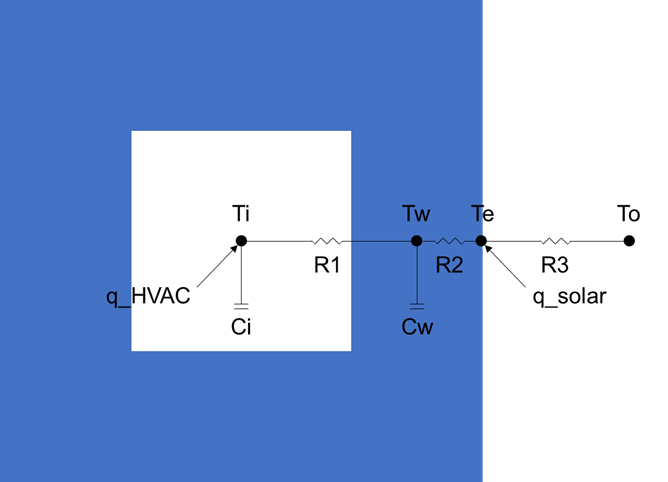

The size of your A marix should be $2\times2$, i.e., $\mathbf{A}=\begin{bmatrix}a_{(1,1)},a_{(1,2)}\\a_{(2,1)},a_{(2,2)}\end{bmatrix}$.</br>
The size of your B marix should be $2\times3$, i.e., $\mathbf{B}=\begin{bmatrix}b_{(1,1)},b_{(1,2)},b_{(1,3)}\\b_{(2,1)},b_{(2,2)},b_{(2,3)}\end{bmatrix}$.</br>

In [ ]:
def simulation(Ci, Cw, R1, R2, R3):
    # continuous time invariant state-space
    A = np.array([[a_11, a_12],
                  [a_21, a_22]]) ###### <-- replace these four elements properly.
    B = np.array([[b_11, b_12, b_13],
                  [b_21, b_22, b_23]]) ###### <-- replace these six elements properly.
    C = np.eye(2) # assume that C is known
    D = np.zeros((2,3)) # assume that D is known
      
    # discrete state-space
    Ad, Bd, Cd, Dd, _ = cont2discrete((A,B,C,D), 10*60) # discretization with 10 minute time interval
    
    x = np.zeros((2, N+1))
    x[0,0] = 20 # initial Ti
    x[1,0] = 15 # initial Tw
    
    # compute states over the simulation period
    for i in range(N):
        q_HVAC_t = q_HVAC[i]
        q_solar_t = q_solar[i]
        To_t = To[i]
        u_t = np.array([q_HVAC_t, q_solar_t, To_t])[:,None] # input vector
        x[:,i+1:i+2] = np.dot(Ad,x[:,i:i+1]) + np.dot(Bd,u_t)
    return x

def objective(ga_instance, solution, solution_idx):
    # scaled for better optimization
    Ci = solution[0] * 1000000
    Cw = solution[1] * 10000000
    R1 = solution[2] * 0.001
    R2 = solution[3] * 0.001
    R3 = solution[4] * 0.001
    
    # run simulation
    x = simulation(Ci, Cw, R1, R2, R3)
    
    # error metric
    metric = ######################################## add an equation ########################################
    return 1/metric

In [ ]:
# parameter estimation with a genetic algorithm
last_fitness = 0
def on_generation(ga_instance):
    global last_fitness
    print(f"Generation = {ga_instance.generations_completed}")
    print(f"Fitness    = {ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]}")
    print(f"Change     = {ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness}")
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]

ga_instance = pygad.GA(num_generations=500,
                       num_parents_mating=10,
                       sol_per_pop=50,
                       gene_space={'low': 0, 'high': 10},
                       num_genes=5,
                       fitness_func=objective,
                       on_generation=on_generation
                      )
ga_instance.run()
ga_instance.plot_fitness()
solution, solution_fitness, solution_idx = ga_instance.best_solution(ga_instance.last_generation_fitness)

In [ ]:
# scale them back
Ci = solution[0] * 1000000
Cw = solution[1] * 10000000
R1 = solution[2] * 0.001
R2 = solution[3] * 0.001
R3 = solution[4] * 0.001

print('Ci:',Ci)
print('Cw:',Cw)
print('R1:',R1)
print('R2:',R2)
print('R3:',R3)

x = simulation(Ci, Cw, R1, R2, R3)

Ti_simulation = x[0,:] # Indoor temperature 
Tw_simulation = x[1,:]

# plotting
t_span = np.arange(0,N+1)
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(Ti, label='Ti_original')
ax[0].plot(Ti_simulation, label='Ti_simulation', linestyle='--')
ax[0].plot(Tw_simulation, label='Tw_simulation')
ax[0].plot(To, label='To')
ax[0].set_xticks(t_span[::6*24],t_span[::6*24]*10/60)
ax[0].set_ylabel('Temperature [$\degree$C]')
ax[0].set_xlabel('Time [hour]')
ax[0].legend()

ax[1].plot(q_HVAC, label='q_HVAC')
ax[1].plot(q_solar, label='q_solar')
ax[1].set_xticks(t_span[::6*24],t_span[::6*24]*10/60)
ax[1].set_ylabel('Energy Rate [W]')
ax[1].set_xlabel('Time [hour]')
ax[1].legend()

plt.show()